In [20]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
%matplotlib inline

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the origional column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df,name,target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x)==str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name,tv)
        df[name2] = l
    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart, we will see more of this chart in the next class.
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Get a new directory to hold checkpoints from a neural network.  This allows the neural network to be
# loaded later.  If the erase param is set to true, the contents of the directory will be cleared.
def get_model_dir(name,erase):
    base_path = os.path.join(".","dnn")
    model_dir = os.path.join(base_path,name)
    os.makedirs(model_dir,exist_ok=True)
    if erase and len(model_dir)>4 and os.path.isdir(model_dir):
        shutil.rmtree(model_dir,ignore_errors=True) # be careful, this deletes everything below the specified path
    return model_dir

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name]-df[name].mean())>=(sd*df[name].std()))]
    df.drop(drop_rows,axis=0,inplace=True)
    
# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low =-1, normalized_high =1, 
                         data_low=None, data_high=None):
    
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])
    
    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
                * (normalized_high - normalized_low) + normalized_low
        


In [21]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("auto-mpg.csv",na_values=['NA','?'])


print("Esses testes foram feitos com um base sobre carros e seus atributos. O objetivo é prever quanto"+
      "o carro fará por litro de combustível (ou quantas milhas por galão). Abaixo segue uma porção dessa base.")        

print("\n")
print(df.head())

#procura por colunas que tenham algum Nan
df.isnull().any()
#corrige Nan
df['horsepower'][df['horsepower'].isnull()] = df.horsepower.mean()
df.isnull().any()
#remove nome
df.drop('name',axis=1,inplace=True)



Esses testes foram feitos com um base sobre carros e seus atributos. O objetivo é prever quantoo carro fará por litro de combustível (ou quantas milhas por galão). Abaixo segue uma porção dessa base.


    mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   
3  16.0          8         304.0       150.0    3433          12.0    70   
4  17.0          8         302.0       140.0    3449          10.5    70   

   origin                       name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  


/home/christian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
from sklearn                        import metrics, svm
from sklearn.linear_model           import LinearRegression
from sklearn.linear_model           import LogisticRegression
from sklearn.tree                   import DecisionTreeClassifier
from sklearn.neighbors              import KNeighborsClassifier
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
from sklearn.naive_bayes            import GaussianNB
from sklearn.svm                    import SVC
from sklearn.svm                    import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


#Caso 1 - Linear Regression sem cross-validation
print("Caso 1 - Linear Regression sem cross-validation")

# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.20, random_state=42) 
#Normalization
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

classifier = LinearRegression()
classifier.fit(x_train_scaled, y_train)
# The mean squared error
print("Mean squared error: %.2f" % np.sqrt(np.mean((classifier.predict(x_test_scaled) - y_test) ** 2)))
pred = classifier.predict(x_test_scaled)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Mean squared error: {}".format(score))
score=cross_val_score(classifier, x_test_scaled, y_test, scoring='neg_mean_squared_error') 
print("Mean squared error: {}".format(score))
# Evaluate success using accuracy
print("Accuracy: %.3f" % classifier.score(X=x_test_scaled,y=y_test))

print("\n\n")

#Caso 2 - Linear Regression com 5 fold cross-validation
# Shuffle
print("Caso 2 - Linear Regression com 5 fold cross-validation")
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.20, random_state=42) 

#Normalization
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_train = np.asmatrix(y_train)
y_test = np.asmatrix(y_test)

classifier = LinearRegression()
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x_train_scaled):
    fold+=1
    print("Fold #{}".format(fold))

    x_train_fold = x_train_scaled[train]
    y_train_fold = y_train[train]
    x_test_fold = x_train_scaled[test]
    y_test_fold = y_train[test]
    
    classifier.fit(x_train_fold, y_train_fold)
    pred = classifier.predict(x_test_fold)
    oos_y.append(y_test_fold)
    oos_pred.append(pred)        

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(y_test_fold,pred))
    print("Fold score (RMSE): {}".format(score))

    # Evaluate success using accuracy
    print("Accuracy: %.3f" % classifier.score(X=x_test_fold,y=y_test_fold))

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_y,oos_pred))
print("\nFinal, out of sample score (RMSE): {}".format(score))    
# The mean squared error
pred = classifier.predict(x_test_scaled)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Final, out of sample score (RMSE): {}".format(score))    
print("Final Accuracy: %.3f" % classifier.score(X=x_test_scaled,y=y_test))

print("\n")

print("\n Tentativa de selecionar melhores features \n")

from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

#Removing features with low variance
print("Original shape: {}".format(np.shape(df.iloc[:,1:])))
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
features = sel.fit_transform(df.iloc[:,1:])
print("Shape apos Removing features with low variance {}".format(np.shape(features))) #nenhuma foi selecionada 
print("\n")

#Tree-based feature selection
clf = ExtraTreesRegressor()
clf = clf.fit(df.iloc[:,1:],df.iloc[:,0:1])
data = np.zeros((1,df.shape[1]-1))
data = pd.DataFrame(data, columns=df.columns[1:])
data.iloc[0] = clf.feature_importances_
print("As features selecionadas com Tree-based feature selection foram: \n")
print(data)

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(df.iloc[:,1:])
print("\n New shape apos Tree-based feature selection: {}".format(X_new.shape))

print("\n Fim tentativa selecionar melhores features \n")

print("Treinando novamente somente com as features relevantes \n")

x_train, x_test, y_train, y_test = train_test_split(X_new, df.iloc[:,0:1], test_size=0.20, random_state=42) 
#Normalization
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

classifier = LinearRegression()
classifier.fit(x_train_scaled, y_train)
# The mean squared error
print("Mean squared error: %.2f" % np.sqrt(np.mean((classifier.predict(x_test_scaled) - y_test) ** 2)))
pred = classifier.predict(x_test_scaled)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Mean squared error: {}".format(score))
score=cross_val_score(classifier, x_test_scaled, y_test, scoring='neg_mean_squared_error') 
print("Mean squared error: {}".format(score))
# Evaluate success using accuracy
print("Accuracy: %.3f" % classifier.score(X=x_test_scaled,y=y_test))



/home/christian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Caso 1 - Linear Regression sem cross-validation
Mean squared error: 3.73
Mean squared error: 3.7294211619172484
Mean squared error: [-17.93147744 -12.4248414  -16.31732339]
Accuracy: 0.805



Caso 2 - Linear Regression com 5 fold cross-validation
Fold #1
Fold score (RMSE): 3.381042537555894
Accuracy: 0.832
Fold #2
Fold score (RMSE): 3.911961086667159
Accuracy: 0.766
Fold #3
Fold score (RMSE): 2.8722021174011263
Accuracy: 0.874
Fold #4
Fold score (RMSE): 3.571258390875969
Accuracy: 0.742
Fold #5
Fold score (RMSE): 3.6208700468964556
Accuracy: 0.808

Final, out of sample score (RMSE): 3.4878372074444934
Final, out of sample score (RMSE): 2.8509271566301924
Final Accuracy: 0.839



 Tentativa de selecionar melhores features 

Original shape: (398, 7)
Shape apos Removing features with low variance (398, 7)


As features selecionadas com Tree-based feature selection foram: 

   cylinders  displacement  horsepower    weight  acceleration      year  \
0   0.324809      0.184751    0.051246  0

In [23]:
classifier = SVR()
#Caso 3 - SVM
# Shuffle
print("Caso 2 - SVM")
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.23, random_state=42) 
#Normalization
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

classifier.fit(x_train_scaled, y_train)

# The mean squared error
pred = classifier.predict(x_test_scaled)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Mean squared error: {}".format(score))
# Evaluate success using accuracy
print("Accuracy: %.3f" % classifier.score(X=x_test_scaled,y=y_test))

print("\n\n")

#Caso 2
# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

print("Caso 2 - SVM com cross-validation")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.20, random_state=42) 

#Normalization
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_train = np.asmatrix(y_train)
y_test = np.asmatrix(y_test)

classifier = SVR()
kf = KFold(5)    
oos_y = []
oos_pred = []
fold = 0

#x = df.as_matrix(columns=df.columns[1:])  
#y = df.as_matrix(columns=['mpg'])


for train, test in kf.split(x_train_scaled):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train_fold = x_train_scaled[train]
    y_train_fold = y_train[train]
    x_test_fold = x_train_scaled[test]
    y_test_fold = y_train[test]
         
    classifier.fit(x_train_fold, y_train_fold)
    pred = classifier.predict(x_test_fold)
    oos_y.append(y_test_fold)
    oos_pred.append(pred)

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(y_test_fold,pred))
    print("Fold score (RMSE): {}".format(score))

    # Evaluate success using accuracy
    print("Accuracy: %.3f" % classifier.score(X=x_test_fold,y=y_test_fold))

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_y,oos_pred))
print("\nFinal, out of sample score (RMSE): {}".format(score))    
# The mean squared error
pred = classifier.predict(x_test_scaled)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Final, out of sample score (RMSE): {}".format(score))    
# Evaluate success using accuracy
print("Final Accuracy: %.3f" % classifier.score(X=x_test_scaled,y=y_test))

Caso 2 - SVM


/home/christian/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error: 2.268577409851733
Accuracy: 0.879



Caso 2 - SVM com cross-validation
Fold #1
Fold score (RMSE): 2.9698418068755643
Accuracy: 0.845
Fold #2
Fold score (RMSE): 2.7273102329770085
Accuracy: 0.881
Fold #3
Fold score (RMSE): 3.8080019671448335
Accuracy: 0.782
Fold #4
Fold score (RMSE): 3.8054219291085762
Accuracy: 0.772
Fold #5
Fold score (RMSE): 2.8166791655109833
Accuracy: 0.869

Final, out of sample score (RMSE): 3.260551172739426
Final, out of sample score (RMSE): 3.0796532294946415
Final Accuracy: 0.826


In [24]:
##Random Forests
from sklearn.ensemble import RandomForestRegressor

# Shuffle
print("Random Forests")
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.20, random_state=42) 


classifier = RandomForestRegressor(n_estimators=10)

classifier.fit(x_train, y_train)

# The mean squared error
pred = classifier.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Mean squared error: {}".format(score))
# Evaluate success using accuracy
print("Accuracy: %.3f" % classifier.score(X=x_test,y=y_test))

print("\n\n")

#Caso 2
# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

print("Random Forests com cross-validation")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.20, random_state=42) 

classifier = RandomForestRegressor(n_estimators=10)
kf = KFold(5)    
oos_y = []
oos_pred = []
fold = 0

#x = df.as_matrix(columns=df.columns[1:])  
#y = df.as_matrix(columns=['mpg'])

for train, test in kf.split(x_train):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train_fold = x_train.as_matrix()[train]
    y_train_fold = y_train.as_matrix()[train]
    x_test_fold = x_train.as_matrix()[test]
    y_test_fold = y_train.as_matrix()[test]
    
    #Normalization
    #scaler = preprocessing.StandardScaler().fit(x_train)
    #x_train_scaled = scaler.transform(x_train)
    #x_test_scaled = scaler.transform(x_test)
    
    classifier.fit(x_train_fold, y_train_fold)
    pred = classifier.predict(x_test_fold)
    oos_y.append(y_test_fold)
    oos_pred.append(pred)        

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(y_test_fold,pred))
    print("Fold score (RMSE): {}".format(score))

    # Evaluate success using accuracy
    print("Accuracy: %.3f" % classifier.score(X=x_test_fold,y=y_test_fold))

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_y,oos_pred))
print("\nFinal, out of sample score (RMSE): {}".format(score))    
# The mean squared error
pred = classifier.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Final, out of sample score (RMSE): {}".format(score))    
# Evaluate success using accuracy
print("Final Accuracy: %.3f" % classifier.score(X=x_test,y=y_test))

Random Forests
Mean squared error: 3.756293718547579
Accuracy: 0.834



Random Forests com cross-validation
Fold #1
Fold score (RMSE): 2.80296048848356
Accuracy: 0.900
Fold #2


/home/christian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/christian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/christian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fold score (RMSE): 3.064793528934698
Accuracy: 0.838
Fold #3
Fold score (RMSE): 2.764750779907657
Accuracy: 0.844
Fold #4
Fold score (RMSE): 2.751170890701134
Accuracy: 0.841
Fold #5
Fold score (RMSE): 2.6796265435128106
Accuracy: 0.881

Final, out of sample score (RMSE): 2.816386015566624
Final, out of sample score (RMSE): 2.8898648324791942
Final Accuracy: 0.877


/home/christian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/christian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/christian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [25]:
##K NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor

# Shuffle
print("KNeighborsRegressor")
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.20, random_state=42) 

#Normalization
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

classifier = KNeighborsRegressor()

classifier.fit(x_train_scaled, y_train)

# The mean squared error
pred = classifier.predict(x_test_scaled)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Mean squared error: {}".format(score))
# Evaluate success using accuracy
print("Accuracy: %.3f" % classifier.score(X=x_test_scaled,y=y_test))

print("\n")

#Caso 2
# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

print("KNeighborsRegressor com cross-validation")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.20, random_state=42) 

#Normalization
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_train = np.asmatrix(y_train)
y_test = np.asmatrix(y_test)


classifier = KNeighborsRegressor()
kf = KFold(5)    
oos_y = []
oos_pred = []
fold = 0

#x = df.as_matrix(columns=df.columns[1:])  
#y = df.as_matrix(columns=['mpg'])

for train, test in kf.split(x_train_scaled):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train_fold = x_train_scaled[train]
    y_train_fold = y_train[train]
    x_test_fold = x_train_scaled[test]
    y_test_fold = y_train[test]
     
    classifier.fit(x_train_fold, y_train_fold)
    pred = classifier.predict(x_test_fold)
    oos_y.append(y_test_fold)
    oos_pred.append(pred)        

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(y_test_fold,pred))
    print("Fold score (RMSE): {}".format(score))

    # Evaluate success using accuracy
    print("Accuracy: %.3f" % classifier.score(X=x_test_fold,y=y_test_fold))

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_y,oos_pred))
print("\nFinal, out of sample score (RMSE): {}".format(score))    
# The mean squared error
pred = classifier.predict(x_test_scaled)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Final, out of sample score (RMSE): {}".format(score))    
# Evaluate success using accuracy
print("Final Accuracy: %.3f" % classifier.score(X=x_test_scaled,y=y_test))


KNeighborsRegressor
Mean squared error: 3.184222039996583
Accuracy: 0.841


KNeighborsRegressor com cross-validation
Fold #1
Fold score (RMSE): 3.4403479111857274
Accuracy: 0.777
Fold #2
Fold score (RMSE): 2.7140836390944187
Accuracy: 0.854
Fold #3
Fold score (RMSE): 2.446166643955395
Accuracy: 0.903
Fold #4
Fold score (RMSE): 4.041414965161945
Accuracy: 0.750
Fold #5
Fold score (RMSE): 2.6845495616967754
Accuracy: 0.873

Final, out of sample score (RMSE): 3.1196841075367887
Final, out of sample score (RMSE): 3.2500338459776077
Final Accuracy: 0.845


In [26]:
from sklearn.neural_network import MLPRegressor

# Shuffle
print("NN MLPRegressor")
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.23, random_state=42) 

#Normalization
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

classifier = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2), random_state=1)

classifier.fit(x_train_scaled, y_train)

# The mean squared error
pred = classifier.predict(x_test_scaled)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Mean squared error: {}".format(score))
# Evaluate success using accuracy
print("Accuracy: %.3f" % classifier.score(X=x_test_scaled,y=y_test))

print("\n")

#Caso 2
# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

print("MLPRegressor com cross-validation")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.20, random_state=42) 

#Normalization
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_train = np.asmatrix(y_train)
y_test = np.asmatrix(y_test)


classifier = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 2), random_state=1)
kf = KFold(5)    
oos_y = []
oos_pred = []
fold = 0

#x = df.as_matrix(columns=df.columns[1:])  
#y = df.as_matrix(columns=['mpg'])

for train, test in kf.split(x_train_scaled):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train_fold = x_train_scaled[train]
    y_train_fold = y_train[train]
    x_test_fold = x_train_scaled[test]
    y_test_fold = y_train[test]
    
    classifier.fit(x_train_fold, y_train_fold)
    pred = classifier.predict(x_test_fold)
    oos_y.append(y_test_fold)
    oos_pred.append(pred)        

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(y_test_fold,pred))
    print("Fold score (RMSE): {}".format(score))

    # Evaluate success using accuracy
    print("Accuracy: %.3f" % classifier.score(X=x_test_fold,y=y_test_fold))

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_y,oos_pred))
print("\nFinal, out of sample score (RMSE): {}".format(score))    
# The mean squared error
pred = classifier.predict(x_test_scaled)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Final, out of sample score (RMSE): {}".format(score))    
# Evaluate success using accuracy
print("Final Accuracy: %.3f" % classifier.score(X=x_test_scaled,y=y_test))




NN MLPRegressor
Mean squared error: 1.974818380298283
Accuracy: 0.941


MLPRegressor com cross-validation
Fold #1
Fold score (RMSE): 2.7817672325823377
Accuracy: 0.873
Fold #2
Fold score (RMSE): 3.071366709789862
Accuracy: 0.821
Fold #3


/home/christian/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold score (RMSE): 2.941369496662038
Accuracy: 0.858
Fold #4
Fold score (RMSE): 2.829714765093805
Accuracy: 0.869
Fold #5
Fold score (RMSE): 2.739366128815406
Accuracy: 0.872

Final, out of sample score (RMSE): 2.875783899939826
Final, out of sample score (RMSE): 3.4824191083684615
Final Accuracy: 0.823


Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin'],
      dtype='object')


{'boxes': [<matplotlib.lines.Line2D at 0x7f869ddb69b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f869dc75cc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f869dc50588>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f869dc507b8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f869ddb6390>,
  <matplotlib.lines.Line2D at 0x7f869dfe7d68>]}

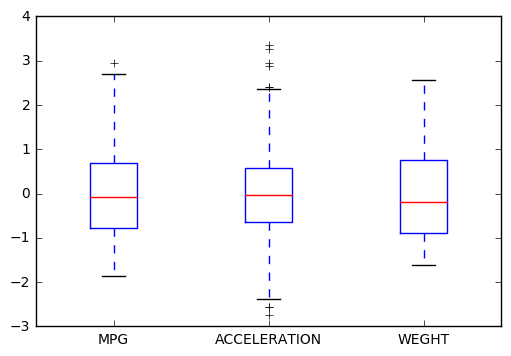

In [27]:
print(df.columns)
encode_numeric_zscore(df,'mpg')
encode_numeric_zscore(df,'acceleration')
encode_numeric_zscore(df,'weight')

plt.boxplot([df.mpg,df.acceleration,df.weight],labels=['MPG','ACCELERATION','WEGHT'])
#plt.boxplot([df.horsepower],labels=['HORSEPOWER'])